In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn import linear_model
 
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('boxoffice.csv',
                 encoding='latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Star Wars: Episode VIII - The Last Jedi,"$620,181,382","$1,332,539,889",Walt Disney Studios Motion Pictures,"$220,009,584","4,232","$317,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi",382
1,The Fate of the Furious,"$226,008,385","$1,236,005,118",Universal Pictures,"$98,786,705","4,310","$250,000,000",PG-13,"Action,Adventure,Thriller",262
2,Wonder Woman,"$412,563,408","$821,847,012",Warner Bros.,"$103,251,471","4,165","$149,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi,War",217
3,Guardians of the Galaxy Vol. 2,"$389,813,101","$863,756,051",Walt Disney Studios Motion Pictures,"$146,510,104","4,347","$200,000,000",PG-13,"Action,Adventure,Comedy,Sci-Fi",241
4,Beauty and the Beast,"$504,014,165","$1,263,521,126",Walt Disney Studios Motion Pictures,"$174,750,616","4,210","$160,000,000",PG,"Family,Fantasy,Musical,Romance",290


In [4]:
df.shape

(2694, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   object
 2   world_revenue     2694 non-null   object
 3   distributor       2694 non-null   object
 4   opening_revenue   2390 non-null   object
 5   opening_theaters  2383 non-null   object
 6   budget            397 non-null    object
 7   MPAA              1225 non-null   object
 8   genres            2655 non-null   object
 9   release_days      2694 non-null   object
dtypes: object(10)
memory usage: 210.6+ KB


In [6]:
df.describe().T

,count,unique,top,freq
title,2694,2468,A Beautiful Planet,3
domestic_revenue,2694,2495,"$11,272,008",3
world_revenue,2694,2501,"$25,681,505",3
distributor,2694,248,Fathom Events,292
opening_revenue,2390,2176,"$4,696",3
opening_theaters,2383,732,1,503
budget,397,124,"$40,000,000",14
MPAA,1225,8,R,568
genres,2655,567,Documentary,351
release_days,2694,457,347,35


In [7]:
#we will predict only domestic_revenue so we don't need world or openening revenue.
to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)

In [8]:
df.isnull().sum() * 100 / df.shape[0]

title                0.000000
domestic_revenue     0.000000
distributor          0.000000
opening_theaters    11.544172
budget              85.263549
MPAA                54.528582
genres               1.447661
release_days         0.000000
dtype: float64

In [9]:
# Handling the null value columns
df.drop('budget', axis=1, inplace=True)
 
for col in ['MPAA', 'genres']:
    df[col] = df[col].fillna(df[col].mode()[0])
    
df.dropna(inplace=True)
 
df.isnull().sum().sum()

0

In [10]:
df['domestic_revenue'].str[1:]

0       620,181,382
1       226,008,385
2       412,563,408
3       389,813,101
4       504,014,165
           ...     
2689    176,040,665
2690    175,750,384
2691    209,726,015
2692    188,045,546
2693    229,024,295
Name: domestic_revenue, Length: 2383, dtype: object

In [11]:
df['domestic_revenue'] = df['domestic_revenue'].str[1:]
 
for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].str.replace(',', '')
 
    # Selecting rows with no null values in the columns on which we are iterating.
    temp = (~df[col].isnull())
    df[temp][col] = df[temp][col].convert_dtypes(float)
 
    df[col] = pd.to_numeric(df[col], errors='coerce')
 


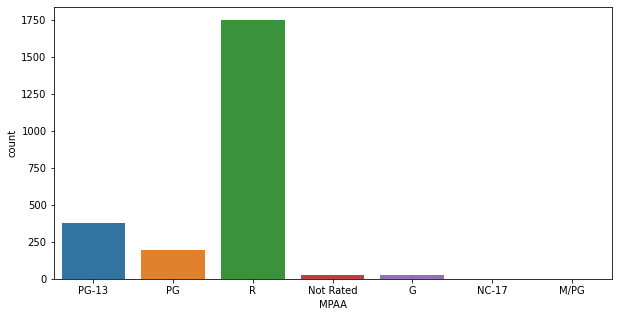

In [12]:
plt.figure(figsize=(10, 5))
sb.countplot(df['MPAA'])
plt.show()

In [13]:
df.groupby('MPAA').mean()['domestic_revenue']

MPAA
G            3.539276e+07
M/PG         5.113500e+05
NC-17        1.368800e+04
Not Rated    4.897703e+05
PG           5.379622e+07
PG-13        5.891966e+07
R            6.591336e+06
Name: domestic_revenue, dtype: float64

#### we can observe that the movies with PG or PG-13 ratings generally have their revenue higher than the other rating class.

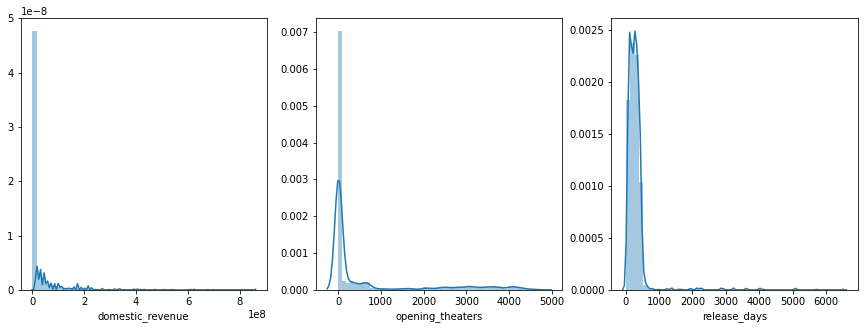

In [14]:
plt.subplots(figsize=(15, 5))
 
features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.show()

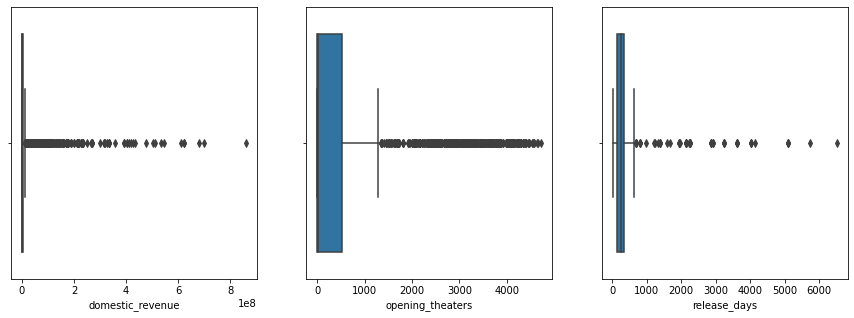

In [15]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.boxplot(df[col])
plt.show()

In [16]:
for col in features:
    df[col] = df[col].apply(lambda x: np.log10(x))

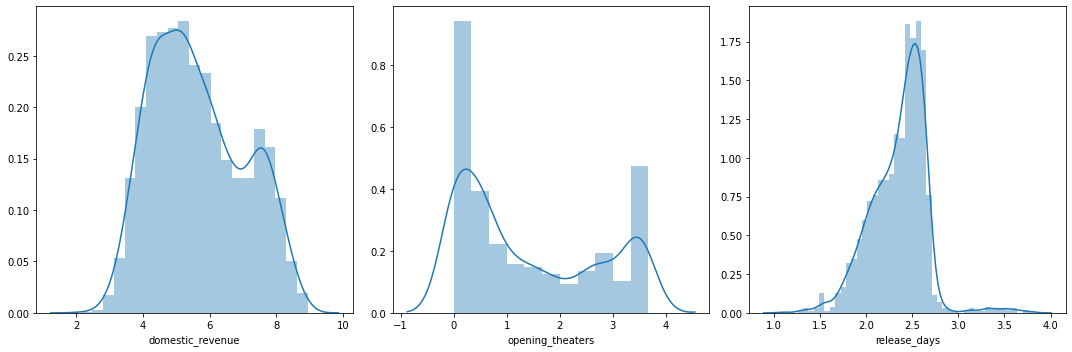

In [17]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()
 
genres = vectorizer.get_feature_names()
for i, name in enumerate(genres):
    df[name] = features[:, i]

df.drop('genres', axis=1, inplace=True)

In [19]:
removed = 0
for col in df.loc[:, 'action':'western'].columns:
 
    # Removing columns having more
    # than 95% of the values as zero.
    if (df[col] == 0).mean() > 0.95:
        removed += 1
        df.drop(col, axis=1, inplace=True)

print(removed)
print(df.shape)

11
(2383, 24)


In [20]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

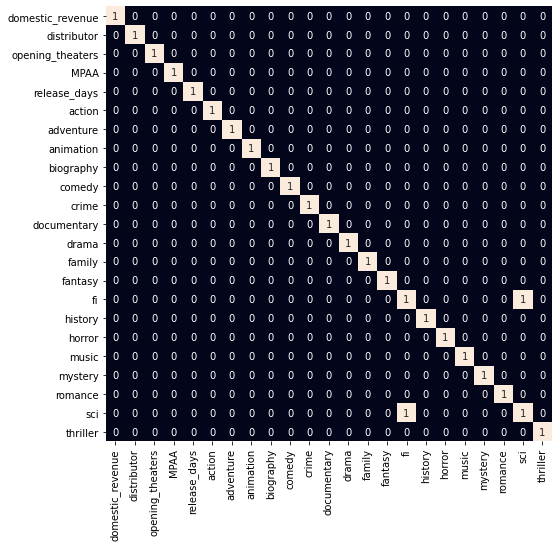

In [21]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

### model development

In [22]:
y=df['domestic_revenue']
x=df.drop(['domestic_revenue','title'],axis=1)

In [23]:
x.shape

(2383, 22)

In [24]:
y.shape

(2383,)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)
print("x train: ", x_train.shape)
print("x test: ",x_test.shape)
print("y train: ", y_train.shape)
print("y test: ",y_test.shape)

x train:  (1906, 22)
x test:  (477, 22)
y train:  (1906,)
y test:  (477,)


In [26]:
lm=linear_model.LinearRegression()
model=lm.fit(x_train,y_train)

In [27]:
model.coef_

array([ 0.00172118,  0.74465146, -0.12420875,  0.84345939, -0.00874033,
        0.1828036 , -0.22488407,  0.47027546,  0.20151888,  0.04182967,
        0.14777921,  0.24494508, -0.12882635,  0.09046234,  0.09996713,
        0.15114849, -0.09095475,  0.10335328,  0.13491734,  0.0417546 ,
        0.09996713,  0.11504956])

In [28]:
model.intercept_

2.7483111627860453

In [29]:
y_pred=model.predict(x_test)

In [30]:
print(metrics.mean_squared_error(y_test,y_pred))

0.6485152858976331


In [31]:
x.head()

,distributor,opening_theaters,MPAA,release_days,action,adventure,animation,biography,comedy,crime,...,family,fantasy,fi,history,horror,music,mystery,romance,sci,thriller
0,217,3.626546,5,2.582063,1,1,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,208,3.634477,5,2.418301,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,218,3.619615,5,2.336460,1,1,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,217,3.638190,5,2.382017,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,217,3.624282,4,2.462398,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0


In [32]:
testdata=[[217,3.626546,5,2.582063,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0]]
print(model.predict(testdata))

[7.84360103]


In [33]:
y.head()

0    8.792519
1    8.354125
2    8.615491
3    8.590856
4    8.702443
Name: domestic_revenue, dtype: float64

In [34]:
print(x)

      distributor  opening_theaters  MPAA  release_days  action  adventure  \
0             217          3.626546     5      2.582063       1          1   
1             208          3.634477     5      2.418301       1          1   
2             218          3.619615     5      2.336460       1          1   
3             217          3.638190     5      2.382017       1          1   
4             217          3.624282     4      2.462398       0          0   
...           ...               ...   ...           ...     ...        ...   
2689          208          3.444201     6      2.829947       0          0   
2690          218          3.611511     4      2.511883       1          0   
2691          217          3.600646     4      2.607455       0          1   
2692          218          3.570543     5      2.225309       1          0   
2693          218          3.607562     5      2.612784       1          1   

      animation  biography  comedy  crime  ...  family  fantasy

In [35]:
x.describe()

,distributor,opening_theaters,MPAA,release_days,action,adventure,animation,biography,comedy,crime,...,family,fantasy,fi,history,horror,music,mystery,romance,sci,thriller
count,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,...,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000
mean,122.852287,1.409804,5.574486,2.351830,0.151490,0.123374,0.063366,0.118758,0.234159,0.110365,...,0.074696,0.096937,0.071758,0.070919,0.076374,0.053714,0.079312,0.126731,0.071758,0.172052
std,63.921611,1.306028,0.893706,0.303659,0.358601,0.328935,0.243670,0.323571,0.423561,0.313410,...,0.262955,0.295934,0.258141,0.256743,0.265652,0.225499,0.270281,0.332741,0.258141,0.377505
min,0.000000,0.000000,0.000000,1.079181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,0.301030,5.000000,2.158362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,116.000000,0.903090,6.000000,2.408240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,181.000000,2.717253,6.000000,2.549003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,226.000000,3.674402,6.000000,3.813381,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
